In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization,GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the dataset
df = pd.read_csv('/home/muzaffar/Desktop/Farhat/paper-000/delta-mfcc/delta-mfcc.csv')  # Change the path accordingly

# Assuming 'word_label' is the last column
label_column = 'word_label'

# Check if the label column is present
if label_column not in df.columns:
    raise KeyError(f"The '{label_column}' column is not present in the DataFrame.")

# Extract features and labels
X = df.iloc[:, :-1].values  # All columns except the last one
y = df[label_column].values

# Encode the labels
le = LabelEncoder()
y = le.fit_transform(y)

# Standardize the input features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Perform 10-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []
all_histories = []

# Number of time steps should be a divisor of the number of features
n_time_steps = 3  # Adjust this value to be a divisor of 39
n_features_per_timestep = X.shape[1] // n_time_steps

# Lists to store true and predicted labels across all folds
all_true_labels = []
all_predicted_labels = []

for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Training Fold {fold + 1}...")

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Reshape the input data for LSTM
    X_train = np.reshape(X_train, (X_train.shape[0], n_time_steps, n_features_per_timestep))
    X_test = np.reshape(X_test, (X_test.shape[0], n_time_steps, n_features_per_timestep))

    # Create the LSTM model with Dropout layers
    model = Sequential()
    model.add(GRU(256, activation='relu', return_sequences=True, input_shape=(n_time_steps, n_features_per_timestep)))
    model.add(BatchNormalization())
    model.add(GRU(128, activation='relu', return_sequences=True))
    model.add(BatchNormalization())
    model.add(GRU(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(len(np.unique(y)), activation='softmax'))

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Create ModelCheckpoint callback to save the best weights
    checkpoint_path = f'model_checkpoint_fold_{fold + 1}.keras'

    model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')

    # Train the model and save the training history
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train, y_train, epochs=30, batch_size=64,
        verbose=1, validation_data=(X_test, y_test),
        callbacks=[early_stopping, model_checkpoint]
    )

    # Save the training history
    with open(f'training_history_fold_{fold + 1}.pkl', 'wb') as f:
        pickle.dump(history.history, f)

    all_histories.append(history.history)

    # Make predictions on the test set
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Store true and predicted labels
    all_true_labels.extend(y_test)
    all_predicted_labels.extend(y_pred)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(accuracy)
    print(f'Fold {fold + 1} - Accuracy: {accuracy}')

# Calculate and print the average accuracy across all folds
average_accuracy = np.mean(fold_accuracies)
print(f'Average Accuracy Across Folds: {average_accuracy}')

# Generate confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(all_true_labels, all_predicted_labels)
print("Classification Report:")
print(class_report)

# Plot accuracy across folds
def plot_learning_behavior(histories, metric='accuracy'):
    plt.figure(figsize=(12, 8))

    for i, history in enumerate(histories):
        plt.plot(history[metric], label=f'Fold {i + 1}')

    plt.title(f'Model {metric.capitalize()} Across Folds')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()

#


2024-07-11 14:09:16.912744: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-11 14:09:17.524865: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Training Fold 1...


2024-07-11 14:09:21.575612: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-11 14:09:21.611392: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-11 14:09:21.611558: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/30


I0000 00:00:1720687165.947477   16417 service.cc:145] XLA service 0x7f114406d8b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720687165.947499   16417 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-07-11 14:09:26.017262: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-11 14:09:26.338551: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


  69/6628 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.1172 - loss: 2.6061  

I0000 00:00:1720687169.610205   16417 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6628/6628 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.3165 - loss: 1.8849 - val_accuracy: 0.5012 - val_loss: 1.3987
Epoch 2/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.4992 - loss: 1.4189 - val_accuracy: 0.5565 - val_loss: 1.2445
Epoch 3/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.5568 - loss: 1.2643 - val_accuracy: 0.5975 - val_loss: 1.1434
Epoch 4/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.5940 - loss: 1.1662 - val_accuracy: 0.6163 - val_loss: 1.0982
Epoch 5/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6204 - loss: 1.1007 - val_accuracy: 0.6371 - val_loss: 1.0368
Epoch 6/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6408 - loss: 1.0409 - val_accuracy: 0.6501 - val_loss: 1.0051
Epoch 7/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6564 - loss: 1.0004 - val_accuracy: 0.6645 - val_loss: 0.9686
Epoch 8/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6704 - loss: 0.9615 - val

/home/muzaffar/anaconda3/envs/tf12/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.3104 - loss: 1.9016 - val_accuracy: 0.4997 - val_loss: 1.4020
Epoch 2/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.4987 - loss: 1.4211 - val_accuracy: 0.5530 - val_loss: 1.2551
Epoch 3/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.5610 - loss: 1.2589 - val_accuracy: 0.5969 - val_loss: 1.1485
Epoch 4/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.5979 - loss: 1.1580 - val_accuracy: 0.6196 - val_loss: 1.0884
Epoch 5/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6240 - loss: 1.0884 - val_accuracy: 0.6373 - val_loss: 1.0381
Epoch 6/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6486 - loss: 1.0255 - val_accuracy: 0.6521 - val_loss: 1.0062
Epoch 7/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6637 - loss: 0.9830 - val_accuracy: 0.6622 - val_loss: 0.9734
Epoch 8/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6762 - loss: 0

/home/muzaffar/anaconda3/envs/tf12/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.3120 - loss: 1.8980 - val_accuracy: 0.5075 - val_loss: 1.3804
Epoch 2/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.5020 - loss: 1.4146 - val_accuracy: 0.5641 - val_loss: 1.2312
Epoch 3/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.5577 - loss: 1.2642 - val_accuracy: 0.6007 - val_loss: 1.1302
Epoch 4/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.5979 - loss: 1.1629 - val_accuracy: 0.6231 - val_loss: 1.0777
Epoch 5/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6243 - loss: 1.0887 - val_accuracy: 0.6380 - val_loss: 1.0397
Epoch 6/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6437 - loss: 1.0370 - val_accuracy: 0.6571 - val_loss: 0.9868
Epoch 7/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6605 - loss: 0.9912 - val_accuracy: 0.6672 - val_loss: 0.9605
Epoch 8/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6719 - loss: 0

/home/muzaffar/anaconda3/envs/tf12/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.3158 - loss: 1.8858 - val_accuracy: 0.4937 - val_loss: 1.4014
Epoch 2/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.4989 - loss: 1.4185 - val_accuracy: 0.5524 - val_loss: 1.2581
Epoch 3/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.5578 - loss: 1.2633 - val_accuracy: 0.5915 - val_loss: 1.1506
Epoch 4/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.5960 - loss: 1.1630 - val_accuracy: 0.6152 - val_loss: 1.0923
Epoch 5/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6224 - loss: 1.0920 - val_accuracy: 0.6323 - val_loss: 1.0501
Epoch 6/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6434 - loss: 1.0359 - val_accuracy: 0.6461 - val_loss: 1.0121
Epoch 7/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6607 - loss: 0.9870 - val_accuracy: 0.6596 - val_loss: 0.9752
Epoch 8/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6746 - loss: 0

/home/muzaffar/anaconda3/envs/tf12/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.3160 - loss: 1.8904 - val_accuracy: 0.5040 - val_loss: 1.3918
Epoch 2/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.5033 - loss: 1.4058 - val_accuracy: 0.5639 - val_loss: 1.2294
Epoch 3/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.5611 - loss: 1.2564 - val_accuracy: 0.5985 - val_loss: 1.1462
Epoch 4/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.5973 - loss: 1.1597 - val_accuracy: 0.6215 - val_loss: 1.0812
Epoch 5/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6224 - loss: 1.0910 - val_accuracy: 0.6406 - val_loss: 1.0306
Epoch 6/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6433 - loss: 1.0353 - val_accuracy: 0.6495 - val_loss: 1.0066
Epoch 7/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6608 - loss: 0.9871 - val_accuracy: 0.6644 - val_loss: 0.9680
Epoch 8/30
6628/6628 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6730 - loss: 0

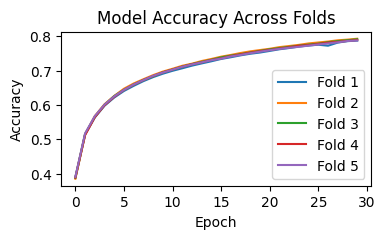

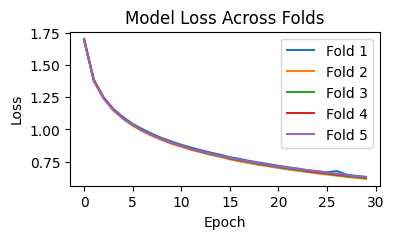

In [2]:

# Plot accuracy across folds
def plot_learning_behavior(histories, metric='accuracy'):
    plt.figure(figsize=(4, 2))

    for i, history in enumerate(histories):
        plt.plot(history[metric], label=f'Fold {i + 1}')

    plt.title(f'Model {metric.capitalize()} Across Folds')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()

# Plot accuracy across folds
plot_learning_behavior(all_histories, metric='accuracy')

# Plot loss across folds
plot_learning_behavior(all_histories, metric='loss')


In [3]:
# Calculate and print the average accuracy across all folds
average_accuracy = np.mean(fold_accuracies)
print(f'Average Accuracy Across Folds: {average_accuracy}')



Average Accuracy Across Folds: 0.7428993952796016


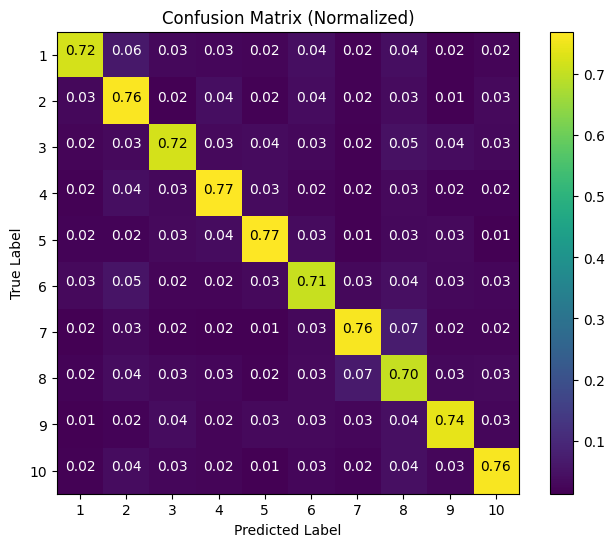

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

# Normalize the confusion matrix by row (true labels)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix as heatmap with annotated percentages
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_normalized, cmap='viridis', interpolation='nearest')

# Choose appropriate text color based on background color
threshold = conf_matrix_normalized.max() / 2.

for i in range(conf_matrix_normalized.shape[0]):
    for j in range(conf_matrix_normalized.shape[1]):
        color = "white" if conf_matrix_normalized[i, j] < threshold else "black"
        plt.text(j, i, format(conf_matrix_normalized[i, j], '.2f'), horizontalalignment="center", color=color)

# Set ticks to be 1 through 10
plt.xticks(np.arange(10), np.arange(1, 11))
plt.yticks(np.arange(10), np.arange(1, 11))

plt.colorbar()
plt.title('Confusion Matrix (Normalized)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [5]:
# Generate classification report
class_report = classification_report(all_true_labels, all_predicted_labels)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.72      0.74     45126
           1       0.69      0.76      0.72     49488
           2       0.76      0.72      0.74     54311
           3       0.77      0.77      0.77     55820
           4       0.78      0.77      0.77     55346
           5       0.71      0.71      0.71     52672
           6       0.78      0.76      0.77     55175
           7       0.63      0.70      0.66     49694
           8       0.78      0.74      0.76     56623
           9       0.78      0.76      0.77     55911

    accuracy                           0.74    530166
   macro avg       0.74      0.74      0.74    530166
weighted avg       0.75      0.74      0.74    530166



In [6]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_12 (GRU)                    │ (None, 3, 256)         │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 3, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_13 (GRU)                    │ (None, 3, 128)         │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 3, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_14 (GRU)                    │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,247,776 (4.76 MB)

 Trainable params: 415,626 (1.59 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 831,254 (3.17 MB)